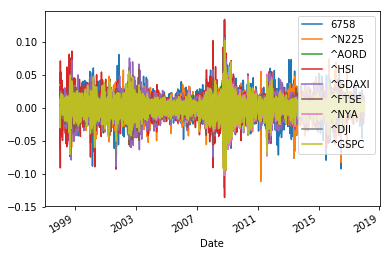

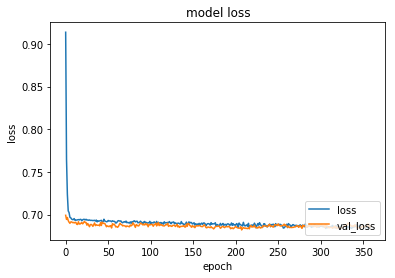

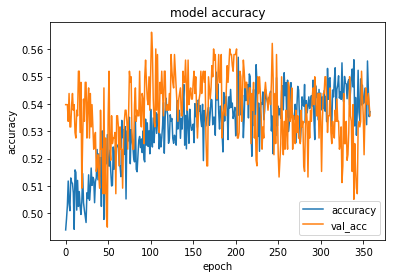

Individual accuracy [0.68045115, 0.4311111]
accuracy 0.566191446029


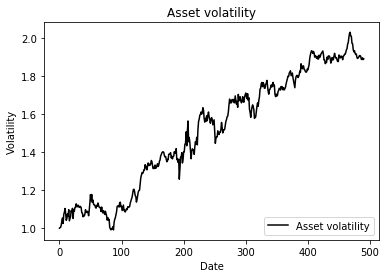

Final_Answer : [ 0.50055164  0.49944833]
Final_Asset : 1.89239510104 



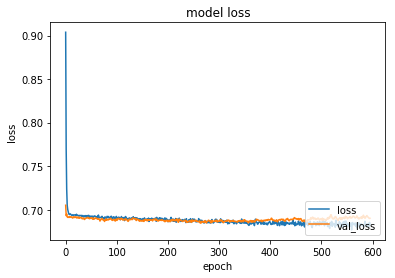

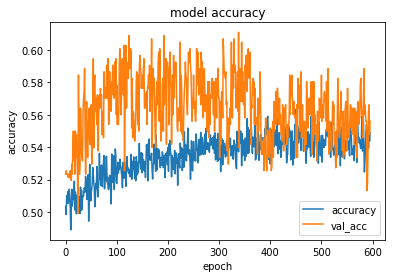

Individual accuracy [0.74319065, 0.46581197]
accuracy 0.61099796334


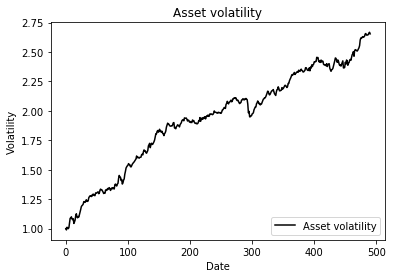

Final_Answer : [ 0.50617629  0.49382362]
Final_Asset : 2.65464599026 



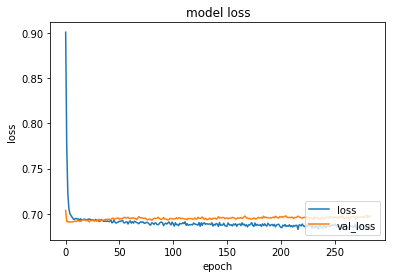

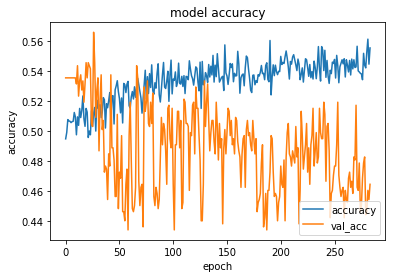

Individual accuracy [0.71102661, 0.3991228]
accuracy 0.566191446029


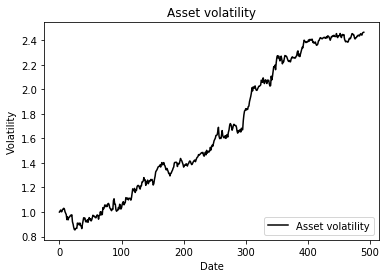

Final_Answer : [ 0.50010788  0.49989212]
Final_Asset : 2.46485367059 



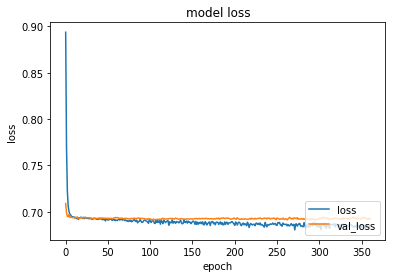

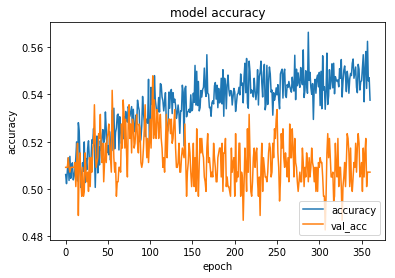

Individual accuracy [0.84799999, 0.23651452]
accuracy 0.547861507128


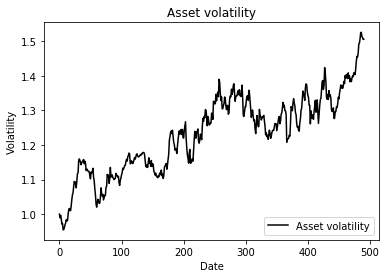

Final_Answer : [ 0.49262983  0.50737017]
Final_Asset : 1.50584398858 



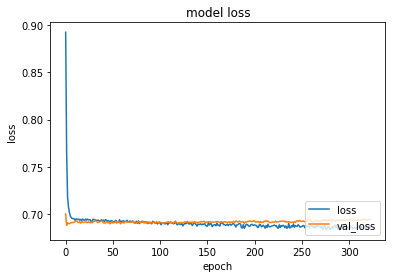

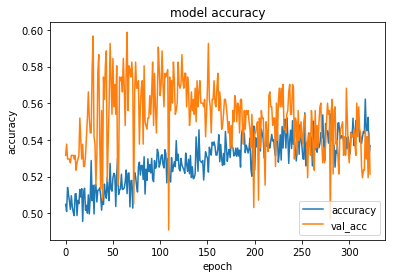

Individual accuracy [0.64367819, 0.54782611]
accuracy 0.598778004073


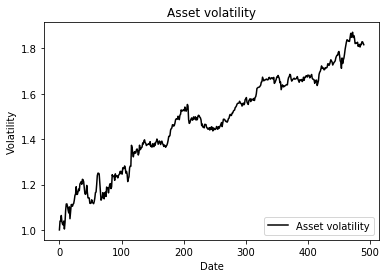

Final_Answer : [ 0.49479759  0.50520241]
Final_Asset : 1.81609544314 

elapsed_time : 1171.2907021045685 [sec]


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from keras_model import Model

INDEIESaa = ['9020',
           '^N225',
           #'^AORD',
           #'^STOXX50E',
           '^FCHI',
           '^GDAXI',
           #'^HSI',
           #'FTSEMIB.MI',
           '^AEX',
           #'^IBEX',
           '^FTSE',
           '^IXIC',
           #'^DJI',
           #'^GSPC',
           #'JPY=X',
           #'EURJPY=X',
           #'GBPJPY=X',
          ]
INDEIES = ['6758',
           '^N225',
           '^AORD',
           '^HSI',
           '^GDAXI',
           '^FTSE',
           '^NYA',
           '^DJI',
           '^GSPC',
          ]
#INDEIES = ['4151','4502','4503','4506','4507','4519','4523','4568']
ANSWER = INDEIES[0]

def getClosing():
    closing = pd.DataFrame()
    for index in INDEIES:
        # na_valuesは文字列"null"のとき空として扱う
        df = pd.read_csv("../data/input5/" + index + ".csv", na_values=["null"])
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date")
        closing[index] = np.log(df["Close"] / df["Close"].shift())
        if index is ANSWER:
            closing[index] = np.log(df["Close"] / df["Open"])
            closing["LH"] = (df["Close"].shift()-df["Low"])*(df["High"]-df["Close"].shift())
    # 空の部分は古いので埋める
    closing = closing.fillna(method="ffill")
    LH = np.array(closing["LH"])
    del closing["LH"]
    #for index in INDEIES:
        #closing[index] = np.log((closing[index]+1e-8) / (closing[index].shift()+1e-8))
        #closing[index] = ((closing[index]+1e-8)-(closing[index].shift()+1e-8)) / (closing[index].shift()+1e-8)
    #グラフ表示
    closing.plot()
    plt.show()
    closing["negative"] = 0
    # closing[ANSWER] < 0 の行のnegativeに 1
    closing.loc[closing[ANSWER] < 0, "negative"] = 1
    closing["positive"] = 0
    # closing[ANSWER] >= 0 の行のpositiveに 1
    closing.loc[closing[ANSWER] >= 0, "positive"] = 1
    return closing, LH

def getTraningData():
    closing, LH = getClosing()
    # 1~3日前のデータを予測に使う
    days_before = range(1,4)
    answers = pd.DataFrame(columns = ["negative", "positive"])
    columns = []
    for index in INDEIES:
        columns += [index + "_" + str(before) for before in days_before]
    features = pd.DataFrame(columns = columns)
    for i in range(max(days_before)+1, len(closing)):
        # 予測の部分は当日のデータ
        answers = answers.append({
            "negative" : closing["negative"].iloc[i],
            "positive" : closing["positive"].iloc[i]}, ignore_index=True)
        data={}
        # ほかの指標は１個前のデータ
        for index in INDEIES:
            for before in days_before :
                data[index + "_" + str(before)] = closing[index].iloc[i - before]
        features = features.append(data, ignore_index=True)
    for i in days_before :
        drop_col = ANSWER+"_"+str(i)
        #del features[drop_col] # 予測するデータの過去データを入れないとき
    LH = LH[max(days_before)+1: len(closing)]
    # 予測する元のデータ , 予測するべきデータ
    return features, answers, LH

if __name__ == "__main__":
    start = time.time()
    features, answers, LH = getTraningData()
    popo = 10
    layers = [50,25]
    for test in range(5,popo):
        model = Model(features,answers,layers,test/popo,(test+1)/popo)
        model.train(1000,16,256)
        model.test()
        model.value(ANSWER+"_1")
    print("elapsed_time :", time.time()-start, "[sec]")